<a href="https://colab.research.google.com/github/Vasiliki655/DSC511-Introduction/blob/main/Semester_Project_DSC_511.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSC 511 - Big Data Analytics - Group Semester Project
## Reviews of restaurants for pre and post-Covid-19 periods
### Spring Semester 2025


In [2]:
!pip install pyspark

In [3]:
!pip install spark-nlp==4.0.0

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline, PipelineModel

import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
from scipy import stats
from sklearn.linear_model import LinearRegression
from datetime import date
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
from wordcloud import WordCloud
warnings.filterwarnings("ignore")
%matplotlib inline

spark = SparkSession.builder.appName("Introduction to Text Analytics using Spark").getOrCreate()

In [ ]:
print("Hello")

Hello


In [ ]:
print("hello1")

hello1


In [ ]:
print("Alice and Bob")

Alice and Bob


In [ ]:
print("hello")

hello


In [ ]:
#hello

In [5]:
#pre-Covid dataset

from google.colab import drive

drive.mount('/content/drive')

file_path0 = "/content/drive/MyDrive/precovid_reviews.csv"

# Load CSV as DataFrame
pre_df = spark.read.options(header='True', inferSchema='True', delimiter=',',multiline = True, escape = '"').csv(file_path0)


# Show the first few rows
pre_df.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------------------+--------------------+-------------------+------+---------+-----------+------------------+------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|            address|state_|     city|postal_code|          latitude|         longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+-------------------+------+---------+-----------+------------------+------------------+-----+------------+-------+--------------------+--------------------+--------------------+-------------------

In [6]:
#post-Covid dataset

from google.colab import drive

drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/postcovid_reviews.csv"

# Load CSV as DataFrame
post_df = spark.read.options(header='True', inferSchema='True', delimiter=',',multiline = True, escape = '"').csv(file_path)


# Show the first few rows
post_df.show(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+--------------------+--------------------+-------------------+------+---------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|            address|state_|     city|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+-------------------+------+---------+-----------+-------------+--------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+---

In [7]:
from pyspark.sql.functions import col, sum

# Count the number of null values per column
post_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in post_df.columns]).show()

+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+
|business_id|name|address|state_|city|postal_code|latitude|longitude|stars|review_count|is_open|categories|hours|review_id|user_id|customer_stars|useful|funny|cool|text_|date_|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+
|          0|   0|      0|     0|   0|          0|       0|        0|    0|           0|      0|         0|    0|        0|      0|             0|     0|    0|   0|    0|    0|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+



In [8]:
pre_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in pre_df.columns]).show()

+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+------+---------+-------+--------------+------+-----+----+-----+-----+
|business_id|name|address|state_|city|postal_code|latitude|longitude|stars|review_count|is_open|categories| hours|review_id|user_id|customer_stars|useful|funny|cool|text_|date_|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+------+---------+-------+--------------+------+-----+----+-----+-----+
|          0|   0|  13409|     0|   0|        384|       0|        0|    0|           0|      0|         0|216501|        0|      0|             0|     0|    0|   0|    1|    0|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+------+---------+-------+--------------+------+-----+----+-----+-----+



# EDA

-> Stars

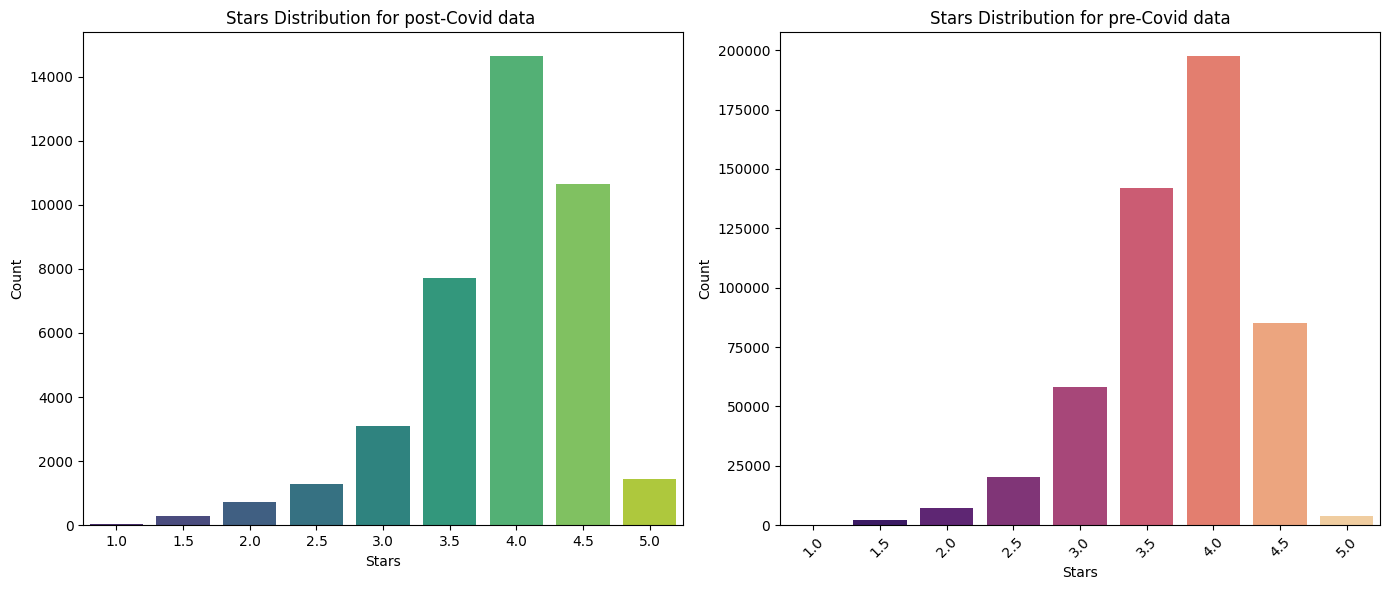

In [10]:
# Convert the DataFrame to a Pandas DataFrame
# Try taking a smaller fraction, e.g., 10%
df_stars_post = post_df.sample(fraction=0.1,seed=42).select('stars').toPandas()
df_stars_pre = pre_df.sample(fraction=0.1,seed=42).select('stars').toPandas()

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of stars from post_df
sns.countplot(ax=axes[0], x='stars', data=df_stars_post, palette='viridis',
              order=sorted(df_stars_post['stars'].dropna().unique()))
axes[0].set_title("Stars Distribution for post-Covid data ")
axes[0].set_xlabel("Stars")
axes[0].set_ylabel("Count")

# Plot 2: Some distribution from other_df
sns.countplot(ax=axes[1], x='stars', data=df_stars_pre, palette='magma',
              order=sorted(df_stars_pre['stars'].dropna().unique()))
axes[1].set_title("Stars Distribution for pre-Covid data")
axes[1].set_xlabel("Stars")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


-> Review count

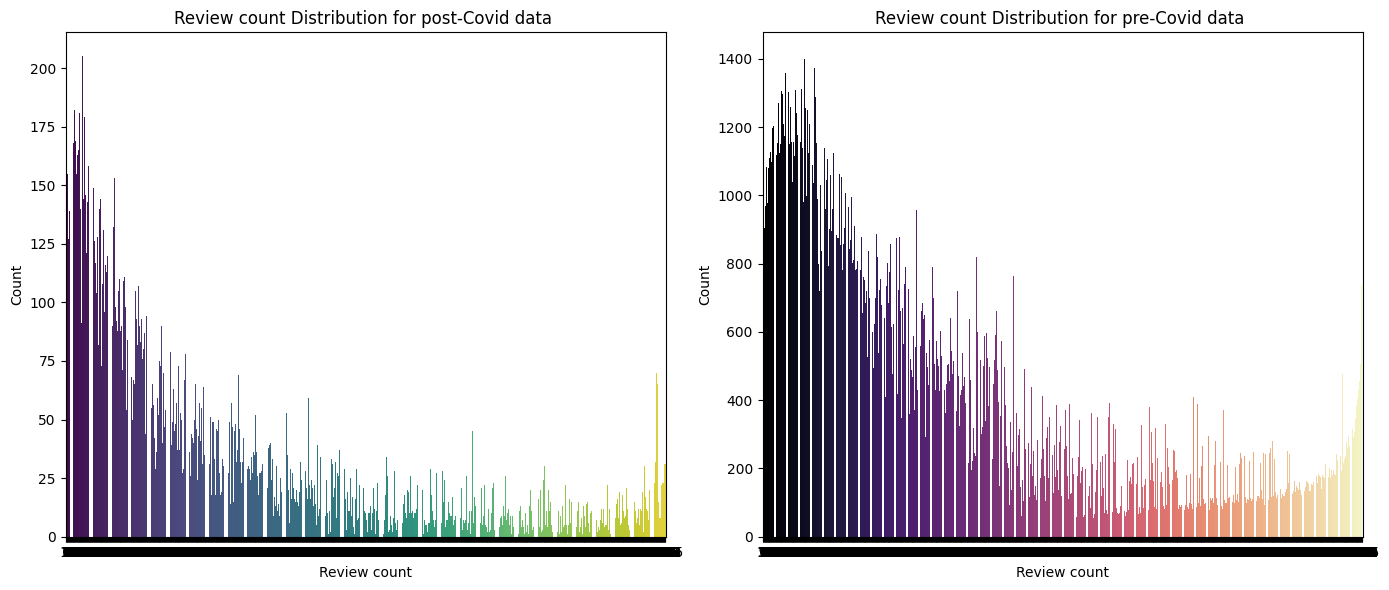

In [14]:
# Convert the DataFrame to a Pandas DataFrame
df_review_count_post = post_df.sample(fraction=0.1).select('review_count').toPandas()
df_review_count_pre = pre_df.sample(fraction=0.1).select('review_count').toPandas()


# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of stars from post_df
sns.countplot(ax=axes[0], x='review_count', data=df_review_count_post, palette='viridis',
              order=sorted(df_review_count_post ['review_count'].dropna().unique()))
axes[0].set_title("Review count Distribution for post-Covid data ")
axes[0].set_xlabel('Review count')
axes[0].set_ylabel("Count")

# Plot 2: Distribution of stars from pre_df
sns.countplot(ax=axes[1], x='review_count', data=df_review_count_pre, palette='magma',
              order=sorted(df_review_count_pre['review_count'].dropna().unique()))
axes[1].set_title("Review count Distribution for pre-Covid data ")
axes[1].set_xlabel('Review count')
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


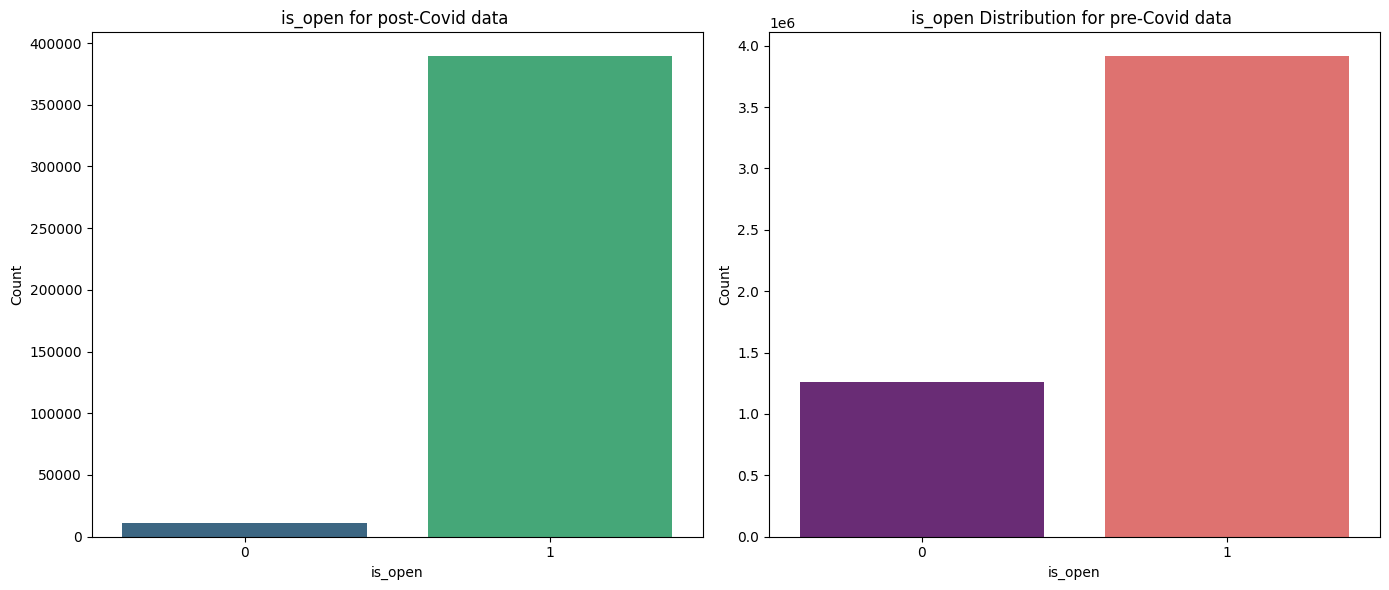

In [49]:
# Convert the DataFrame to a Pandas DataFrame
df_is_open_post = post_df.select("is_open").toPandas()
df_is_open_pre = pre_df.select("is_open").toPandas()

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of stars from post_df
sns.countplot(ax=axes[0], x='is_open', data=df_is_open_post, palette='viridis')
axes[0].set_title("is_open for post-Covid data ")
axes[0].set_xlabel('is_open')
axes[0].set_ylabel("Count")

# Plot 2: Distribution of stars from pre_df
sns.countplot(ax=axes[1], x='is_open', data=df_is_open_pre, palette='magma')
axes[1].set_title("is_open Distribution for pre-Covid data ")
axes[1].set_xlabel('is_open')
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()



-> Customer Stars

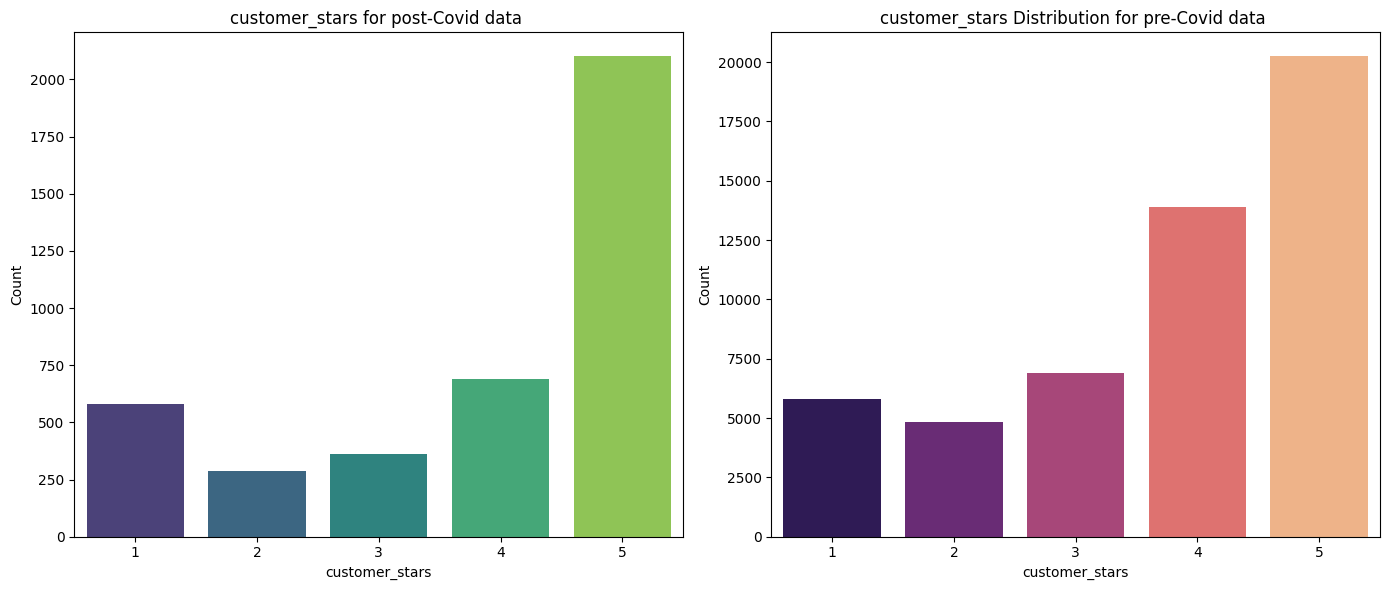

In [16]:
df_stars_post = post_df.sample(fraction=0.01).select('customer_stars').toPandas()
df_stars_pre = pre_df.sample(fraction=0.01).select('customer_stars').toPandas()


# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of stars from post_df
sns.countplot(ax=axes[0], x='customer_stars', data=df_stars_post, palette='viridis',
              order=sorted(df_stars_post['customer_stars'].dropna().unique()))
axes[0].set_title("customer_stars for post-Covid data ")
axes[0].set_xlabel('customer_stars')
axes[0].set_ylabel("Count")

# Plot 2: Distribution of stars from pre_df
sns.countplot(ax=axes[1], x='customer_stars', data=df_stars_pre, palette='magma',
              order=sorted(df_stars_pre['customer_stars'].dropna().unique()))
axes[1].set_title("customer_stars Distribution for pre-Covid data ")
axes[1].set_xlabel('customer_stars')
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

-> Useful

KeyError: 'useful'

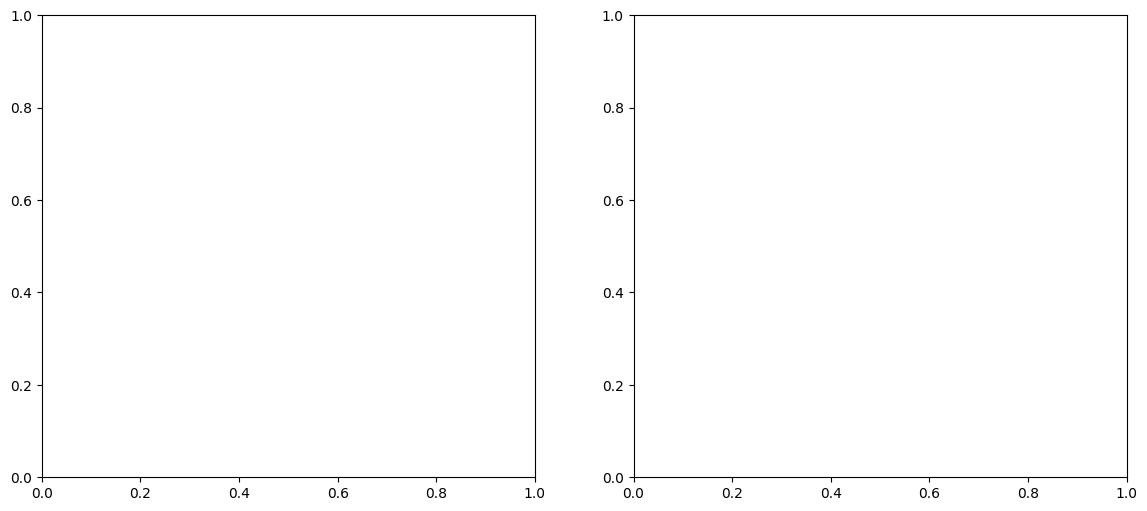

In [37]:
df_useful_post = post_df.sample(fraction=0.01).select('useful').toPandas()
df_useful_pre = pre_df.sample(fraction=0.01).select('useful').toPandas()

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of stars from post_df
sns.countplot(ax=axes[0], x='useful', data=df_stars_post, palette='viridis',
              order=sorted(df_stars_post['useful'].dropna().unique()))
axes[0].set_title("useful for post-Covid data ")
axes[0].set_xlabel('useful')
axes[0].set_ylabel("Count")

# Plot 2: Distribution of stars from pre_df
sns.countplot(ax=axes[1], x='useful', data=df_stars_pre, palette='magma',
              order=sorted(df_stars_pre['useful'].dropna().unique()))
axes[1].set_title("Useful Distribution for pre-Covid data ")
axes[1].set_xlabel('useful')
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


-> Funny

In [ ]:
df_funny_post = post_df.sample(fraction=0.01).select('funny').toPandas()
df_funny_pre = pre_df.sample(fraction=0.01).select('funny').toPandas()

# Set up side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Distribution of stars from post_df
sns.countplot(ax=axes[0], x='funny', data=df_funny_post, palette='viridis',
              order=sorted(df_funny_post['funny'].dropna().unique()))
axes[0].set_title("funny for post-Covid data ")
axes[0].set_xlabel('funny')
axes[0].set_ylabel("Count")

# Plot 2: Distribution of stars from pre_df
sns.countplot(ax=axes[1], x='funny', data=df_funny_pre, palette='magma',
              order=sorted(df_funny_pre['funny'].dropna().unique()))
axes[1].set_title("funny Distribution for pre-Covid data ")
axes[1].set_xlabel('funny')
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


## Hours column

In [22]:
post_df.select("hours").show(5)

+--------------------+
|               hours|
+--------------------+
|{Monday -> 0:0-0:...|
|{Monday -> 0:0-0:...|
|{Monday -> 5:0-13...|
|{Monday -> 12:0-2...|
|{Monday -> 11:30-...|
+--------------------+
only showing top 5 rows



In [21]:
post_df.select("hours").printSchema()

root
 |-- hours: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)



In [20]:
# convert the hours column into dictionary

# Define the schema for the 'hours' column as a Map[String, String]
schema = MapType(StringType(), StringType())

# Convert the 'hours' column from string to a MapType
post_df = post_df.withColumn("hours", from_json(post_df["hours"], schema))

# Verify the schema
post_df.printSchema()

AnalysisException: [DATATYPE_MISMATCH.UNEXPECTED_INPUT_TYPE] Cannot resolve "entries" due to data type mismatch: Parameter 1 requires the "STRING" type, however "hours" has the type "MAP<STRING, STRING>".;
'Project [business_id#149, name#150, address#151, state_#152, city#153, postal_code#154, latitude#155, longitude#156, stars#157, review_count#158, is_open#159, categories#160, from_json(MapType(StringType,StringType,true), hours#874, Some(Etc/UTC)) AS hours#896, review_id#162, user_id#163, customer_stars#164, useful#165, funny#166, cool#167, text_#168, date_#169]
+- Project [business_id#149, name#150, address#151, state_#152, city#153, postal_code#154, latitude#155, longitude#156, stars#157, review_count#158, is_open#159, categories#160, from_json(MapType(StringType,StringType,true), hours#161, Some(Etc/UTC)) AS hours#874, review_id#162, user_id#163, customer_stars#164, useful#165, funny#166, cool#167, text_#168, date_#169]
   +- Relation [business_id#149,name#150,address#151,state_#152,city#153,postal_code#154,latitude#155,longitude#156,stars#157,review_count#158,is_open#159,categories#160,hours#161,review_id#162,user_id#163,customer_stars#164,useful#165,funny#166,cool#167,text_#168,date_#169] csv


In [23]:
df = post_df.withColumn("monday_hours", expr("hours['Monday']"))
df.select("monday_hours").show(truncate=False)

+------------+
|monday_hours|
+------------+
|0:0-0:0     |
|0:0-0:0     |
|5:0-13:0    |
|12:0-21:0   |
|11:30-22:0  |
|0:0-0:0     |
|0:0-0:0     |
|11:30-22:0  |
|0:0-0:0     |
|11:0-22:0   |
|11:0-21:0   |
|11:0-21:0   |
|16:0-21:0   |
|11:0-21:0   |
|17:0-23:0   |
|NULL        |
|5:0-17:0    |
|NULL        |
|NULL        |
|NULL        |
+------------+
only showing top 20 rows



In [24]:
## Check for invalid values

import re

# Define a function to check if all values match the "HH:MM-HH:MM" pattern
def contains_non_time_values(hours_map):
    if hours_map is None:
        return False  # No hours means no invalid values
    time_pattern = re.compile(r"^\d{1,2}:\d{1,2}-\d{1,2}:\d{1,2}$")  # Pattern for "HH:MM-HH:MM"
    return any(not time_pattern.match(value) for value in hours_map.values())

# Register UDF
contains_invalid_values_udf = udf(contains_non_time_values, BooleanType())

# Filter rows where hours contain non-time values
df_invalid = post_df.filter(contains_invalid_values_udf(df["hours"]))

# Show rows with invalid values
df_invalid.select("hours").show(truncate=False)

+-----+
|hours|
+-----+
+-----+



In [25]:
## Replace 0:0-0:0 with the word "closed"

# Define UDF to replace '0:0-0:0' with 'Closed'
def replace_closed(hours_map):
    if hours_map is None:
        return None
    return {k: ("Closed" if v == "0:0-0:0" else v) for k, v in hours_map.items()}

# Register UDF
replace_closed_udf = udf(replace_closed, MapType(StringType(), StringType()))

# Apply transformation to replace "0:0-0:0" with "Closed"
df = df.withColumn("hours", replace_closed_udf(df["hours"]))

# Show the updated DataFrame
df.select("hours").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|hours                                                                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{Thursday -> 11:30-22:0, Monday -> Closed, Friday -> 11:30-22:0, Sunday -> 11:30-22:0, Wednesday -> 11:30-22:0, Saturday -> 11:30-22:0}                           |
|{Thursday -> 11:0-0:0, Monday -> Closed, Friday -> 11:0-0:0, Sunday -> 10:0-0:0, Wednesday -> 11:0-0:0, Tuesday -> 11:0-0:0, Saturday -> 10:0-1:0}                |
|{Thursday -> 5:0-13:0, Monday -> 5:0-13:0, Friday -> 5:0-13:0, Sunday -> 6:0-13:0, Wednesday -> 5:0-13:0, Tuesday -> 5:0-13:0, Saturday -> 5:30-13:0}             |
|{Thursday

In [26]:
df = df.withColumn("monday_hours", expr("hours['Monday']"))
df.select("monday_hours").show(truncate=False)

+------------+
|monday_hours|
+------------+
|Closed      |
|Closed      |
|5:0-13:0    |
|12:0-21:0   |
|11:30-22:0  |
|Closed      |
|Closed      |
|11:30-22:0  |
|Closed      |
|11:0-22:0   |
|11:0-21:0   |
|11:0-21:0   |
|16:0-21:0   |
|11:0-21:0   |
|17:0-23:0   |
|NULL        |
|5:0-17:0    |
|NULL        |
|NULL        |
|NULL        |
+------------+
only showing top 20 rows



In [27]:
## check if all values "0:0-0:0" have been replaced

from pyspark.sql.functions import col, map_values

# Extract map values and filter for '0:0-0:0'
df_zero_values_remaining = df.filter(
    expr("array_contains(map_values(hours), '0:0-0:0')")
)

df_zero_values_remaining.show(truncate=False)

+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+------------+
|business_id|name|address|state_|city|postal_code|latitude|longitude|stars|review_count|is_open|categories|hours|review_id|user_id|customer_stars|useful|funny|cool|text_|date_|monday_hours|
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+------------+
+-----------+----+-------+------+----+-----------+--------+---------+-----+------------+-------+----------+-----+---------+-------+--------------+------+-----+----+-----+-----+------------+



Count how many businesses have null hours for all days of the week.

In [30]:
## Find records with null values in the hours column or where all days have null values

from pyspark.sql.functions import col, size, map_values

# Filter rows where 'hours' is null or where all values in the 'hours' map are null
df_filtered = df.filter(
    (col('hours').isNull()) |  # Check if the 'hours' column is null
    ((size(map_values(col('hours'))) > 0) &  # Check if the map has any entries
     (col('hours').getItem('Monday').isNull() &
      col('hours').getItem('Tuesday').isNull() &
      col('hours').getItem('Wednesday').isNull() &
      col('hours').getItem('Thursday').isNull() &
      col('hours').getItem('Friday').isNull() &
      col('hours').getItem('Saturday').isNull() &
      col('hours').getItem('Sunday').isNull())
    )
)

df_filtered.count()

12232

In [31]:
df.count()

400295

In [42]:
## Identify entries with unusually short opening hours.

from pyspark.sql.functions import col, udf, explode, when
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType
import re

# 1. UDF to parse the hours map (or string if it's not a map)
def parse_hours_string(hours_data):
    result = []

    # Check if the hours_data is None
    if not hours_data:
        return result

    # If it's a dictionary/map (like {"Monday": "11:30-22:00", "Tuesday": "Closed"})
    if isinstance(hours_data, dict):
        for day, time in hours_data.items():
            if time and time.lower() == 'closed':
                result.append((day, None, None))
            elif time:
                try:
                    open_time, close_time = time.split('-')
                    open_time = re.sub(r'(\d{1,2}):(\d{1})$', r'\1:0\2', open_time.strip())
                    close_time = re.sub(r'(\d{1,2}):(\d{1})$', r'\1:0\2', close_time.strip())
                    result.append((day, open_time, close_time))
                except:
                    result.append((day, None, None))
    else:
        # If it's a string, fallback to the previous method of parsing
        hours_str = hours_data.strip('{}')
        entries = hours_str.split(',')
        for entry in entries:
            try:
                day, time = entry.strip().split('->')
                day = day.strip()
                time = time.strip()
                if time.lower() == 'closed':
                    result.append((day, None, None))
                else:
                    open_time, close_time = time.split('-')
                    open_time = re.sub(r'(\d{1,2}):(\d{1})$', r'\1:0\2', open_time.strip())
                    close_time = re.sub(r'(\d{1,2}):(\d{1})$', r'\1:0\2', close_time.strip())
                    result.append((day, open_time, close_time))
            except:
                result.append((None, None, None))

    return result


# Define the schema for the output
parse_schema = ArrayType(StructType([
    StructField("day", StringType(), True),
    StructField("open", StringType(), True),
    StructField("close", StringType(), True),
]))

# Register the UDF
parse_hours_udf = udf(parse_hours_string, parse_schema)

# Apply the UDF to parse the hours column
df_parsed = df.withColumn("parsed_hours", parse_hours_udf(col("hours")))

# Step 2: Define the UDF to convert time to minutes
def time_to_minutes(time_str):
    if time_str:
        try:
            h, m = map(int, time_str.split(':'))
            return h * 60 + m
        except:
            return None
    return None

time_to_minutes_udf = udf(time_to_minutes, IntegerType())

# Step 3: Exploding and calculating duration
df_exploded = df_parsed.withColumn("hour_info", explode("parsed_hours")) \
    .withColumn("open_min", time_to_minutes_udf(col("hour_info.open"))) \
    .withColumn("close_min", time_to_minutes_udf(col("hour_info.close"))) \
    .withColumn("duration", col("close_min") - col("open_min"))

# Step 4: Add flag for short duration (less than 120 minutes)
df_flagged = df_exploded.withColumn("is_short_range", when(col("duration") < 120, 1).otherwise(0))

# Step 5: Group by business_id and aggregate flag
df_with_flag = df_flagged.groupBy("business_id").agg(
    max_("is_short_range").alias("has_short_range")
)

df_with_flag.show(truncate=False)

df_with_flag.show()


+----------------------+---------------+
|business_id           |has_short_range|
+----------------------+---------------+
|TYDCjEMga3cm7k638hKhTg|0              |
|3ZVgig7uux9jVtEZna5NgA|0              |
|2I1zJBC3QVMM0o3Awa_SfA|0              |
|GrLNk_EE831QDAhaSAZpWA|1              |
|O_BAT_rvszHYBNEM6z0tcQ|0              |
|mSo-QZ-soa01QzowFHS__Q|0              |
|BiagqSINoC8h1GSvHzZhZw|0              |
|8Lnid7N3bcAWY--CIqwOlA|0              |
|dcAzi-fNs05qLl3lwHXUQQ|0              |
|iJx2D_pT82l2INSCoTrnpA|0              |
|KgCm-vYEVwSszwr1DN5dbQ|0              |
|iHHnZb1YEP9vRXOc6-7Nrw|0              |
|3EJXNrznfD63bz5HIezDDQ|0              |
|yoLQdtXSktAXuVvumq2ceg|0              |
|Ukr4_xiBTUPOJ8ySPNrNoA|0              |
|CJn2VFl76Wc8EX0b_x3fnA|1              |
|3KqpiLDAjeeMmZeU-Il_ng|0              |
|ThOLQb-gzAYgvnIG4Kmlxg|0              |
|PkmsrSoqd6t8iCnNopEsUw|1              |
|-VVUUPK0ytYjpJ_S76wQYg|0              |
+----------------------+---------------+
only showing top

In [44]:
df_with_flag.where(col("has_short_range")==1).count()

5324

Define periods:
- Morning: 06:00-12:00
- Afternoon: 12:00-17:00
- Evening: 17:00 -23:00
- LateNight: 23:00- 06:00

In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
import datetime

# Define a UDF to categorize the period based on opening and closing times
def categorize_period(opening_closing_str):
    try:
        opening, closing = opening_closing_str.split('-')
        opening_hour, opening_minute = map(int, opening.split(':'))
        closing_hour, closing_minute = map(int, closing.split(':'))

        # Combine the time into a datetime object for comparison
        opening_time = datetime.time(opening_hour, opening_minute)
        closing_time = datetime.time(closing_hour, closing_minute)

        # Define time ranges (assuming the times are in the format "HH:MM")
        if opening_time >= datetime.time(6, 0) and closing_time <= datetime.time(12, 0):
            return 'Morning'
        elif opening_time >= datetime.time(12, 0) and closing_time <= datetime.time(17, 0):
            return 'Afternoon'
        elif opening_time >= datetime.time(17, 0) and closing_time <= datetime.time(23, 0):
            return 'Evening'
        elif closing_time >= datetime.time(23, 0) or opening_time <= datetime.time(6, 0):
            return 'Late Night'
        else:
            return 'Unknown'
    except Exception as e:
        return 'Closed'

# Register UDF with Spark
categorize_period_udf = udf(categorize_period, StringType())

# Add new column 'period' by applying the UDF on each day in the 'hours' map
df_with_period = df.withColumn(
    'period_Monday',
    categorize_period_udf(col('hours').getItem('Monday'))  # Example for Monday, repeat for other days if needed
)

df_with_period.show(truncate=False)


+----------------------+--------------------------------+---------------------------------+------+------------+-----------+-------------+--------------+-----+------------+-------+-------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+----------------------+--------------+------+-----+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df_with_period = df_with_period.withColumn(
    'period_Tuesday',
    categorize_period_udf(col('hours').getItem('Tuesday'))  # Example for Monday, repeat for other days if needed
)
df_with_period = df_with_period.withColumn(
    'period_Wednesday',
    categorize_period_udf(col('hours').getItem('Wednesday'))  # Example for Monday, repeat for other days if needed
)
df_with_period = df_with_period.withColumn(
    'period_Thursday',
    categorize_period_udf(col('hours').getItem('Thursday'))  # Example for Monday, repeat for other days if needed
)
df_with_period = df_with_period.withColumn(
    'period_Friday',
    categorize_period_udf(col('hours').getItem('Friday'))  # Example for Monday, repeat for other days if needed
)
df_with_period = df_with_period.withColumn(
    'period_Saturday',
    categorize_period_udf(col('hours').getItem('Saturday'))  # Example for Monday, repeat for other days if needed
)
df_with_period = df_with_period.withColumn(
    'period_Sunday',
    categorize_period_udf(col('hours').getItem('Sunday'))  # Example for Monday, repeat for other days if needed
)

In [ ]:
from pyspark.sql.functions import col

# Select only columns whose name contains the word 'period'
df_with_period.select([col(column) for column in df_with_period.columns if 'period' in column.lower()]).show(truncate=False)

+-------------+--------------+----------------+---------------+-------------+---------------+
|period_Sunday|period_Tuesday|period_Wednesday|period_Thursday|period_Friday|period_Saturday|
+-------------+--------------+----------------+---------------+-------------+---------------+
|Unknown      |Closed        |Unknown         |Unknown        |Unknown      |Unknown        |
|Morning      |Morning       |Morning         |Morning        |Morning      |Morning        |
|Late Night   |Late Night    |Late Night      |Late Night     |Late Night   |Late Night     |
|Unknown      |Unknown       |Unknown         |Morning        |Unknown      |Unknown        |
|Unknown      |Unknown       |Unknown         |Unknown        |Unknown      |Unknown        |
|Morning      |Late Night    |Late Night      |Late Night     |Morning      |Morning        |
|Unknown      |Unknown       |Unknown         |Unknown        |Unknown      |Unknown        |
|Unknown      |Unknown       |Unknown         |Unknown      

## Correlations between the two datasets

In [46]:
post_df.columns

['business_id',
 'name',
 'address',
 'state_',
 'city',
 'postal_code',
 'latitude',
 'longitude',
 'stars',
 'review_count',
 'is_open',
 'categories',
 'hours',
 'review_id',
 'user_id',
 'customer_stars',
 'useful',
 'funny',
 'cool',
 'text_',
 'date_']

In [51]:
pre_df.show()

+--------------------+--------------------+--------------------+------+---------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|         business_id|                name|             address|state_|     city|postal_code|          latitude|          longitude|stars|review_count|is_open|          categories|               hours|           review_id|             user_id|customer_stars|useful|funny|cool|               text_|              date_|
+--------------------+--------------------+--------------------+------+---------+-----------+------------------+-------------------+-----+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------+------+-----+----+--------------------+-------------------+
|EXOsmAB1s71WePlQk...|Linwood Grill & B...|   